In [63]:
import os

import pandas as pd
import numpy as np
import imageio.v2 as imageio

from graphviz import Digraph
from IPython.display import Image as ImageDisplay
from PIL import ImageDraw
from PIL import Image
from PIL import ImageFont

In [347]:
mc_example = {'NYC': [.25,0,.75,1],
              'Paris': [.25,.25,0,0],
              'Cairo': [.25,.25,.25,0],
              'Seoul': [.25,.5,0,0]}

mc = pd.DataFrame(data = mc_example, index = ['NYC', 'Paris', 'Cairo', 'Seoul'])
mc

,NYC,Paris,Cairo,Seoul
NYC,0.25,0.25,0.25,0.25
Paris,0.00,0.25,0.25,0.50
Cairo,0.75,0.00,0.25,0.00
Seoul,1.00,0.00,0.00,0.00


In [348]:
mc.iloc[0].index

Index(['NYC', 'Paris', 'Cairo', 'Seoul'], dtype='object')

In [349]:
mc.iloc[0]

NYC      0.25
Paris    0.25
Cairo    0.25
Seoul    0.25
Name: NYC, dtype: float64

In [350]:
np.random.choice(mc.iloc[0].index, p=mc.iloc[0])

'Seoul'

In [139]:
mc.index.get_loc('Paris')

1

In [140]:
mc.iloc[mc.index.get_loc('Paris')].index

Index(['NYC', 'Paris', 'Cairo', 'Seoul'], dtype='object')

In [141]:
mc.iloc[mc.index.get_loc('Paris')]

NYC      0.00
Paris    0.25
Cairo    0.25
Seoul    0.50
Name: Paris, dtype: float64

In [352]:
travel_sim = []

# get row 0th, then get index of item 0th -> NYC
city = mc.iloc[0].index[0]

# append into travel_sim
travel_sim.append(city)

# get the next visited city randomly choice based on known probability
travel_sim.append(np.random.choice(mc.iloc[0].index, # get index of row 0th
                                   p=mc.iloc[0] # get probability of row 0th
                                   ))
print('first print', travel_sim)

# get the next city using previous city probability
while len(travel_sim)<25:
    city = np.random.choice(mc.iloc[mc.index.get_loc(city)].index,
                            p = mc.iloc[mc.index.get_loc(city)]
                            )
    travel_sim.append(city)
travel_sim


first print ['NYC', 'Seoul']


['NYC',
 'Seoul',
 'Cairo',
 'NYC',
 'Cairo',
 'NYC',
 'NYC',
 'Cairo',
 'NYC',
 'Cairo',
 'NYC',
 'Seoul',
 'NYC',
 'Seoul',
 'NYC',
 'NYC',
 'Cairo',
 'NYC',
 'Paris',
 'Paris',
 'Cairo',
 'NYC',
 'NYC',
 'NYC',
 'NYC']

In [143]:
def matrix_power(matrix, power):
  if power == 0:
    return np.identity(len(matrix))
  elif power == 1:
    return matrix
  else:
    return np.dot(matrix, matrix_power(matrix, power-1))
     

In [144]:
matrix_power(mc.to_numpy(), 2)

array([[0.5   , 0.125 , 0.1875, 0.1875],
       [0.6875, 0.0625, 0.125 , 0.125 ],
       [0.375 , 0.1875, 0.25  , 0.1875],
       [0.25  , 0.25  , 0.25  , 0.25  ]])

In [145]:
initial_dist = np.asarray([0,0,0,1])

mc_p2 = matrix_power(mc.to_numpy(),2)
print(mc_p2)
np.dot(initial_dist,mc_p2)

[[0.5    0.125  0.1875 0.1875]
 [0.6875 0.0625 0.125  0.125 ]
 [0.375  0.1875 0.25   0.1875]
 [0.25   0.25   0.25   0.25  ]]


array([0.25, 0.25, 0.25, 0.25])

In [82]:
def baseline_data(region_list,
                  remove_self_flight=False):
    # create adjacency matrix
    data = {}
    region_count = len(region_list)
    for i in region_list:
        if remove_self_flight:
            # to prevent self flight, the probability calculation
            # can be done by 1/(region_count-1) and set the
            # probability of self flight to 0
            data[i] = [1/(region_count-1)]*region_count
            data[i][region_list.index(i)] = 0
        else:
            # to accomodate self flight, the probability calculation
            # will be same on all nodes
            data[i] = [1/region_count]*region_count
    
    # convert matrix to dataframe
    df = pd.DataFrame(data = data,
                      index = [*data]) #list of data keys
    df = df.round(2)
    return df

def block_nodes(df, 
                node_1=None, 
                node_2=None, 
                remove_self_flight=False):
    if node_1 == None and node_2 == None:
        pass
    else:
        # set edge between node_1 and node_2 to 0
        df.at[node_1, node_2] = 0
        df.at[node_2, node_1] = 0
        
        # get node index loc
        node_1_idx = df.index.get_loc(node_1)
        node_2_idx = df.index.get_loc(node_2)
        
        # region count
        region_list = df.index.to_list()
        region_count = len(region_list)
        
        # re-calculate other edge values
        if remove_self_flight:
            # to prevent self flight, the probability calculation
            # can be done by 1/(region_count-2);
            # Notes: (-1 for removing self flight and another -1 for removing blocked node] and set the
            # probability of self flight to 0
            node_1_prob_list = [1/(region_count-2)]*region_count
            node_1_prob_list[region_list.index(node_1)] = 0
            node_2_prob_list = [1/(region_count-2)]*region_count
            node_2_prob_list[region_list.index(node_2)] = 0
        else:
            node_1_prob_list = [1/(region_count-1)]*region_count
            node_2_prob_list = [1/(region_count-1)]*region_count
        
        
        node_1_prob_list[node_2_idx] = 0
        df.loc[df.index == node_1, region_list] = node_1_prob_list
        
        node_2_prob_list[node_1_idx] = 0
        df.loc[df.index == node_2, region_list] = node_2_prob_list
    return df

def preprocess_data(df):
    # convert adjacency matrix into edgelist table
    df = df.rename_axis('source')\
            .reset_index()\
            .melt('source', value_name='weight', var_name='target')\
            .reset_index(drop=True)\
            .round(2)
    return df

# Input data from dataframe into graph network
def create_graph_network(df,
                         colored,
                         index= ''):
    # Declare Graph Network Template
    G = Digraph(format='jpeg')
    G.attr(rankdir='LR', size='8,5')
    G.attr('node', shape='circle')
    
    nodelist = []
    for _, row in df.iterrows():
        node1, node2, weight = [str(i) for i in row]
        if float(weight) == 0.0:
            continue
        else:
            
            if node1 not in nodelist:
                if node1 == colored:
                    G.node(node1, style='filled', fillcolor='#40e0d0')
                else:
                    G.node(node1)
                nodelist.append(node1)
            if node2 not in nodelist:
                if node2 == colored:
                    G.node(node2, style='filled', fillcolor='#40e0d0')
                else:
                    G.node(node2)
                nodelist.append(node2)

            G.edge(node1,node2, label = weight)
    
    # render graph and save as image
    if index!='':
        if int(index)<10:
            index = f'0{index}'
    fname = f'./markov_chain_{index}_{colored}'
    G.render(fname, view=False)
    save_as = f'{fname}.jpeg'
    return save_as

def generate_gif(png_dir = './',
                 save_as = './markov_chain.gif',
                 duration=1000):
    images = []
    for file_name in sorted(os.listdir(png_dir)):
        if file_name.endswith('.jpeg') and not file_name.endswith('_None.jpeg'):
            file_path = os.path.join(png_dir, file_name)
            
            # add step info
            img = Image.open(file_path)
            img_draw = ImageDraw.Draw(img)
            img_draw.text((10, 10), 'STEP: '+file_path.split('markov_chain_')[1][:2], fill='black')
            img.save(file_path)
            
            images.append(imageio.imread(file_path))
    imageio.mimsave(save_as, images, 'GIF', duration=duration)
    return save_as

def clear_all_generated_files():
    mydir = './'
    filelist = [ f for f in os.listdir(mydir) if f.startswith("markov_chain") ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))
    return None

def travel_simulation(df,
                      init_region,
                      dest_region):
    travel_sim = []

    # append into travel_sim
    region = init_region
    travel_sim.append(region)

    # get the next visited city randomly choice based on known probability
    travel_sim.append(np.random.choice(df.iloc[0].index, # get index of row 0th
                                       p=df.iloc[0] # get probability of row 0th
                                      ))

    # get the next city using previous city probability
    while region != dest_region:
        region = np.random.choice(df.iloc[df.index.get_loc(region)].index,
                                  p = df.iloc[df.index.get_loc(region)]
                                 )
        travel_sim.append(region)
    return travel_sim

def matrix_power(matrix, power):
  if power == 0:
    return np.identity(len(matrix))
  elif power == 1:
    return matrix
  else:
    return np.dot(matrix, matrix_power(matrix, power-1))

In [83]:
# clear previous  all generated files
clear_all_generated_files()

# declare matrix
region_list = ['Ttukseom', 'Gunja', 'Wangsimni', 'Dapsimni']
remove_self_flight = False
base_df = baseline_data(region_list, remove_self_flight)
prep_base_df = preprocess_data(base_df)

print('BASELINE MATRIX ')
print(base_df)
base_img = create_graph_network(prep_base_df,colored=None)

# block nodes
node_1 = 'Wangsimni'
node_2 = 'Dapsimni'
blocked_df = block_nodes(base_df, node_1, node_2,remove_self_flight)
print(f'\n BLOCKED MATRIX BETWEEN {node_1} AND {node_2}')
print(blocked_df)

# preprocess data
prep_blocked_df = preprocess_data(blocked_df)

# render graph network
colored_list = ['']
for i in colored_list:
    save_as = create_graph_network(prep_blocked_df, i)

# generate gif
gif_img = generate_gif()

BASELINE MATRIX 
           Ttukseom  Gunja  Wangsimni  Dapsimni
Ttukseom       0.25   0.25       0.25      0.25
Gunja          0.25   0.25       0.25      0.25
Wangsimni      0.25   0.25       0.25      0.25
Dapsimni       0.25   0.25       0.25      0.25

 BLOCKED MATRIX BETWEEN Wangsimni AND Dapsimni
           Ttukseom     Gunja  Wangsimni  Dapsimni
Ttukseom   0.250000  0.250000   0.250000  0.250000
Gunja      0.250000  0.250000   0.250000  0.250000
Wangsimni  0.333333  0.333333   0.333333  0.000000
Dapsimni   0.333333  0.333333   0.000000  0.333333


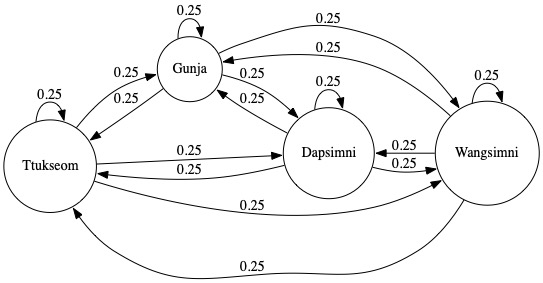

In [84]:
ImageDisplay(base_img)

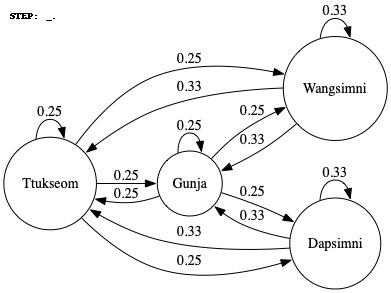

In [85]:
ImageDisplay(gif_img)

In [86]:
selected_df = blocked_df
travel_simulated = travel_simulation(selected_df,
                  init_region='Wangsimni',
                  dest_region='Dapsimni'
                  )
print(f'Step: {len(travel_simulated)-1}')
travel_simulated


Step: 9


['Wangsimni',
 'Ttukseom',
 'Ttukseom',
 'Gunja',
 'Gunja',
 'Wangsimni',
 'Wangsimni',
 'Gunja',
 'Gunja',
 'Dapsimni']

In [87]:
base_df

,Ttukseom,Gunja,Wangsimni,Dapsimni
Ttukseom,0.250000,0.250000,0.250000,0.250000
Gunja,0.250000,0.250000,0.250000,0.250000
Wangsimni,0.333333,0.333333,0.333333,0.000000
Dapsimni,0.333333,0.333333,0.000000,0.333333


In [88]:
# clear previous  all generated files
clear_all_generated_files()

# render graph network
colored_list = travel_simulated
prep_selected_df = preprocess_data(selected_df)
for i in range(len(colored_list)):
    save_as = create_graph_network(prep_selected_df, colored_list[i], index=str(i))

# generate gif
travel_img = generate_gif(save_as= './markov_chain_travel_sim.gif')

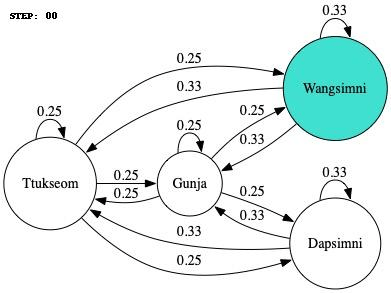

In [89]:
ImageDisplay(travel_img)

# Calculate n-step probability matrix

The UAV is starting the trip from Wangsimni.
What the probability of ending in Gunja is two trips from now?

In [50]:
# Region Name: Ttukseom  Gunja  Wangsimni  Dapsimni
# Region id:    0           1       2       3

initial_dist = np.asarray([0,0,1,0])


df_trip_2 = matrix_power(blocked_df.to_numpy(),2)

np.dot(initial_dist,df_trip_2)

array([0.27777778, 0.27777778, 0.27777778, 0.16666667])

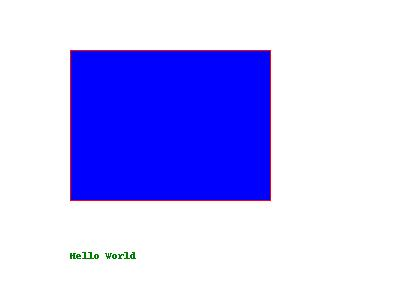

In [73]:
from PIL import Image, ImageDraw
blank_image = Image.new('RGB', (400, 300), 'white')
img_draw = ImageDraw.Draw(blank_image)
img_draw.rectangle((70, 50, 270, 200), outline='red', fill='blue')
img_draw.text((70, 250), 'Hello World', fill='green')
blank_image.save('./drawn_image.jpg')
ImageDisplay('./drawn_image.jpg')